# Extracted selected AOI

In [5]:
import sys  
sys.path.insert(0, '../src')

import utils as ut
import geopandas as gpd
import rasterio as rs

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from tqdm import tqdm
import os

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [8]:
os.listdir('../data/')

['.ipynb_checkpoints',
 'esti_aoi.geojson',
 'S2GM_Q10_20200701_20200930_Esti_new_STD_v1.3.0_1500454',
 'u2018_clc2018_v2020_20u1_raster100m']

In [9]:
aois = gpd.read_file('../data/esti_aoi.geojson')
aois.head()

,id,geometry
0,3,"MULTIPOLYGON (((666944.942 6433413.978, 666944..."
1,1,"MULTIPOLYGON (((514427.000 6537807.152, 514427..."
2,2,"MULTIPOLYGON (((622871.222 6536201.692, 622871..."
3,4,"MULTIPOLYGON (((542483.508 6483794.866, 542483..."


In [10]:
aois.crs

<Projected CRS: EPSG:3301>
Name: Estonian Coordinate System of 1997
Axis Info [cartesian]:
- X[north]: Northing (metre)
- Y[east]: Easting (metre)
Area of Use:
- name: Estonia - onshore and offshore.
- bounds: (20.37, 57.52, 28.2, 60.0)
Coordinate Operation:
- name: Estonian National Grid
- method: Lambert Conic Conformal (2SP)
Datum: Estonia 1997
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

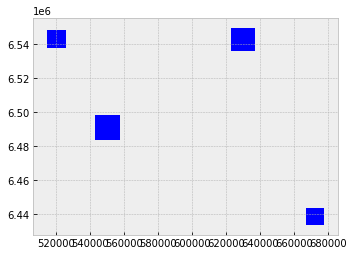

In [11]:
aois.plot()

In [16]:
# Clip the AOIs from S2 images
for i,geom in enumerate(aois.geometry):
    out_path = f'../features/patches/patch_s2_0{i+1}_ee.tif'
    ut.clip_area_of_interest(geom,'../features/mosaics_S2/all_bands_ee.tif',out_path)

In [38]:
# Clip the AIOs from LULC images
for i in tqdm(range(4)):
    out_path = f'../features/patches/patch_lulc_0{i+1}_ee.tif'
    source_img = f'../features/patches/patch_s2_0{i+1}_ee.tif'
    orginal_img = '../features/lulc_Corine2018/lulc_10m_ee.tif'
    ut.exract_boundry(orginal_img,source_img,out_path)

100%|██████████| 4/4 [00:01<00:00,  3.89it/s]


In [39]:
s2_img = rs.open('../features/patches/patch_s2_01_ee.tif').read([3,2,1])
lulc_img = rs.open('../features/patches/patch_lulc_01_ee.tif').read()

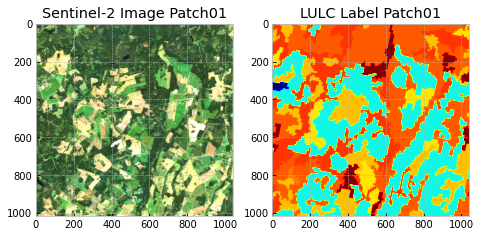

In [40]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Sentinel-2 Image Patch01')
plt.imshow(np.clip(np.moveaxis(s2_img,0,-1) * 5/5000, 0, 1))
plt.subplot(232)
plt.title('LULC Label Patch01')
plt.imshow(np.moveaxis(lulc_img,0,-1)[:,:,0], cmap='jet')
plt.show()

In [48]:
# Calculate the indexes for patches
for i in tqdm(range(4)):
    out_path = f'../features/patches/patch_index_0{i+1}_ee.tif'
    in_img = f'../features/patches/patch_s2_0{i+1}_ee.tif'
    img = rs.open(in_img)
    array = img.read()
    indexes = ut.index_calculator(array).all_indexes()
    
    with rs.open(out_path,"w",
                       driver='GTiff',
                       count=8,
                       transform = img.transform,
                       width= img.width,
                       height= img.height,
                       nodata=65535,
                       dtype='float32',
                       crs="epsg:3301",) as output_file:
        output_file.write(indexes.astype('float32'))

 50%|█████     | 2/4 [00:00<00:00,  2.19it/s]../src/utils.py:230: RuntimeWarning: invalid value encountered in true_divide
  index_ndre = (self.B08 - self.B05) / (self.B08 + self.B05)
100%|██████████| 4/4 [00:02<00:00,  1.79it/s]


In [49]:
# Stack all S2 & LULC & indexes images
items = os.listdir('../features/patches/')
start_with = ["_01_ee.tif","_02_ee.tif","_03_ee.tif","_04_ee.tif"]

for i,wrd in tqdm(enumerate(start_with)):
    imgs_list = ut.list_files_with_absolute_paths('../features/patches/',endswith=wrd)
    imgs_list.sort()
    out_path=f'../features/p0{i+1}_stack_ee.tif'
    ut.stack(imgs_list,out_path)

4it [00:03,  1.16it/s]
